In [1]:
import numpy as np
from scipy.stats import lognorm, uniform, norm
import matplotlib.pyplot as plt
import os
from fitting_models_rothenhoefer import value_efficient_coding_moment
# off warning
import warnings
# scipy.optimize.minimize to minimize fitting function
import pickle as pkl


# fitting

In [2]:
data = np.genfromtxt('rothenhoefer.csv', delimiter=',')

In [3]:
# function that estimates not only slope but also intercept
def estimate_slope_fitwith_intercept(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(x, y)
    return model.coef_[0][0]


In [4]:
from scipy.optimize import curve_fit
def estimate_slope(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x.reshape(-1)
    y = y.reshape(-1)
    def linear_model(xx, a):
        return a * xx
    popt, _ = curve_fit(linear_model,x, y)
    return popt

# estimate_slope_intercept to get slope and intercept from data
slope = estimate_slope(data[:,0], data[:,1])

In [5]:
print(slope)

[1.1095298]


In [6]:
def fitting_line(params):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[1]
    # others uses res.x
    R_t = 150
    # R_t = params[4]
    slope_scale_norm = params[2]
    slope_scale_unfm = params[3]
    spon_act = 5
    samples = 10000

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # if any of alpha is larger than 1, return a large number
    if alpha_norm > 1 or alpha_unfm > 1:
        return 1e5

    # print(slope)


    # cal slopes using spon_act

    ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = np.random.poisson(ec_norm.neurons_[i][2500], samples)
        norm_0 = np.random.poisson(ec_norm.neurons_[i][5000], samples)
        norm_pos = np.random.poisson(ec_norm.neurons_[i][7500], samples)

        #take mean of norm_neg, norm_0, norm_pos
        norm_neg = np.mean(norm_neg)
        norm_0 = np.mean(norm_0)
        norm_pos = np.mean(norm_pos)

        # norm_neg -= spon_act
        # norm_0 -= spon_act
        # norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = np.random.poisson(ec_unfm.neurons_[i][2500], samples)
        unfm_0 = np.random.poisson(ec_unfm.neurons_[i][5000], samples)
        unfm_pos = np.random.poisson(ec_unfm.neurons_[i][7500], samples)

        #take mean of unfm_neg, unfm_0, unfm_pos
        unfm_neg = np.mean(unfm_neg)
        unfm_0 = np.mean(unfm_0)
        unfm_pos = np.mean(unfm_pos)

        # unfm_neg -= spon_act
        # unfm_0 -= spon_act
        # unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    if np.any(np.array(norm_res)<0) or np.any(np.array(unfm_res)<0):
        # print(norm_res)
        return 1e5



    # caculate distance of unfm_res and norm_res from the line y=slope*x+intercept

    dist = np.array(norm_res) - slope*np.array(unfm_res)

    # sum of squared error
    dist = np.sum(dist**2)


    # print what will be returned
    print(dist)

    # get difference between data[:,0] and unfm_res, data[:,1] and norm_res
    # return sum of squared difference
    return dist

# set seed paramters that linspaced between 0 and 1, 0 and 10
params_0 = np.linspace(0.01,1,3)
params_1 = np.linspace(0.01,1,3)
params_2 = np.linspace(0.01,10,3)
params_3 = np.linspace(0.01,10,3)
# params_4 = np.linspace(50,200,3)

# make paramters using meshgrid
param = np.array(np.meshgrid(params_0, params_1, params_2, params_3)).T.reshape(-1,4)
# param = np.array(np.meshgrid(params_0, params_1, params_2, params_3, params_4)).T.reshape(-1,5)



In [7]:

warnings.filterwarnings('ignore')


# scipy.optimize.minimize to minimize fitting function
os.makedirs('res_fit_to_empirical_rothenhoefer_line_alpha_fit_slopeslope', exist_ok=True)


from scipy.optimize import minimize
# use param
# for but every 10th number in range of len(param)
now = True
if now:
    for i in range(len(param)):
        # do the followings only if there is no file that need to be saved
        if os.path.isfile('./res_fit_to_empirical_rothenhoefer_line_alpha_fit_slopeslope/'+'fitting_'+str(i)+'.pkl'):
            continue

        # print param with its name in a line
        print('param_'+str(i)+':', param[i].tolist())

        # line that separates
        print('------------------------------------')
        # try:
        res = minimize(fitting_line, param[i].tolist(), method='Powell', options={'disp': True})
        # except:
        #     continue
        # res = minimize(fitting, [0.5,0.5,0.5,0.5], method='Nelder-Mead', options={'disp': True})

        # save res to res_fit_to_empirical_rothenhoefer using pickle
        with open('./res_fit_to_empirical_rothenhoefer_line_alpha_fit_slopeslope/'+'fitting_'+str(i)+'.pkl', 'wb') as f:
            pkl.dump(res, f)



param_50: [0.505, 1.0, 10.0, 5.005]
------------------------------------
11584.00707408692
11564.845267755318
4067.3557384407395
4762.035217459699
4056.359243804454
4067.934204265079
4072.5599183865374
4051.7975049454863
13388.131685435339
5357.425639467772
4067.2577050802383
4047.34749562913
4051.694610677357
4045.857213021065
4045.8220961284587
4047.309986731748
4051.531134003576
4042.166731510497
4039.3382847461226
4008.617436914669
4060.3667520940235
4068.715853907069
4233.4340046479265
3722.193935264646
3020.9344485082484
964.1101251806153
1905.16035601938
1394.1003180359903
2464.404845293216
909.6397388216749
946.9935302075905
887.6377514195335
908.8359408441607
900.5646395575577
770.7345669906706
630.4886954945954
548.8352622145286
525.7180481549472
518.4404805954551
528.5484674600586
525.2433620003208
528.2600052386019
533.7344422994752
523.3136245813939
522.4179318978133
525.4018772649636
10501.265904928656
3386.926746729736
279.92167245962
186.4631624727005
223.20062333627874

In [8]:
data = np.genfromtxt('rothenhoefer.csv', delimiter=',')

# after fitting, not arbitrary

## all at once

In [9]:
# load all files in res_fit_to_empirical_rothenhoefer
files = os.listdir('./res_fit_to_empirical_rothenhoefer_line_alpha_fit_slopeslope')
files = [f for f in files if f.endswith('.pkl')]
files.sort()

# make empty list
res = []
# for every file in files|
for f in files:
    # open file using pickle
    with open('./res_fit_to_empirical_rothenhoefer_line_alpha_fit_slopeslope/'+f, 'rb') as f:
        res.append(pkl.load(f))


# ...and sorting in ascending order of fun
res_sorted = sorted(res, key=lambda x: x.fun)


# find that has lowest fun
res = res[np.argmin([r.fun for r in res])]
# print res
print(res)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 28.860375068553964
       x: [ 5.290e-01  5.345e-01  1.793e+00  8.490e+00]
     nit: 6
   direc: [[-1.325e-04 -2.054e-03  4.969e-02  2.003e-01]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]
           [-1.546e-02  4.502e-03  1.624e-01  1.132e+00]]
    nfev: 442


In [11]:
# load all files in res_fit_to_empirical_rothenhoefer
files = os.listdir('./res_fit_to_empirical_rothenhoefer_alpha_fit')
files = [f for f in files if f.endswith('.pkl')]
files.sort()

# make empty list
res = []
# for every file in files
for f in files:
    # open file using pickle
    with open('./res_fit_to_empirical_rothenhoefer_alpha_fit/'+f, 'rb') as f:
        res.append(pkl.load(f))


# ...and sorting in ascending order of fun
res_sorted = sorted(res, key=lambda x: x.fun)


# find that has lowest fun
res = res[np.argmin([r.fun for r in res])]
# print res
print(res)


In [96]:
# ec_norm and ec_unfm with the fitted parameters
params = res.x

N_neurons = 40
alpha_norm = params[0]
alpha_unfm =params[1]
# others uses res.x
slope_scale_norm = params[2]
slope_scale_unfm = params[3]
R_t = 100
# R_t = params[4]
spon_act = 5
samples = 10000

# cal slopes using spon_act

ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)


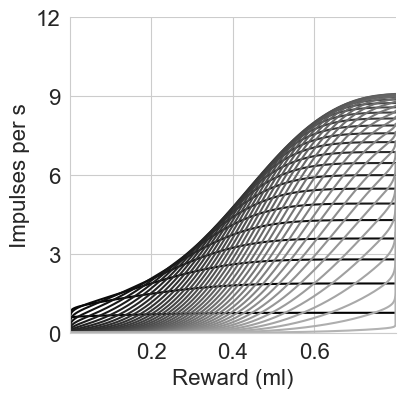

In [97]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
for i in range(ec_norm.N):
    plt.plot(ec_norm.x, ec_norm.neurons_[i], color=str(colors[i]))
    ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12])

plt.xlim([0, 0.8])
plt.ylim([0, 12])
plt.savefig('./figures_rothenhoefer/'+'neuron_norm_pop.png', bbox_inches="tight")
plt.show()



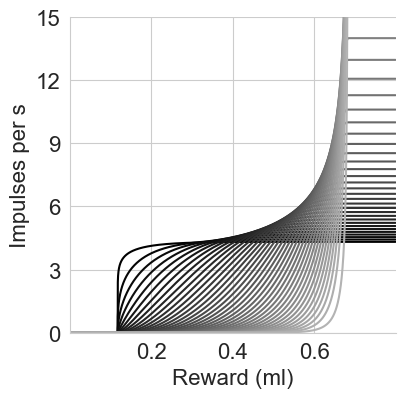

In [98]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
for i in range(ec_unfm.N):
    plt.plot(ec_unfm.x, ec_unfm.neurons_[i], color=str(colors[i]))
    ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12,15])

plt.xlim([0, 0.8])
plt.ylim([0, 15])
plt.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop.pdf', bbox_inches="tight")
plt.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop.png', bbox_inches="tight")
plt.show()



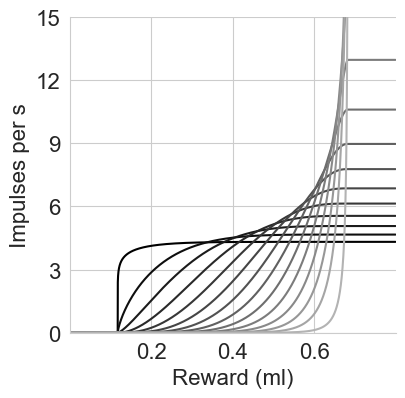

In [99]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_unfm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_unfm.x, ec_unfm.neurons_[i], color=str(colors[i]))
        ymax.append(ec_unfm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12,15])

plt.xlim([0, 0.8])
plt.ylim([0, 15])
fig.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop_subsample.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'neuron_unfm_pop_subsample.pdf', bbox_inches="tight")
plt.show()



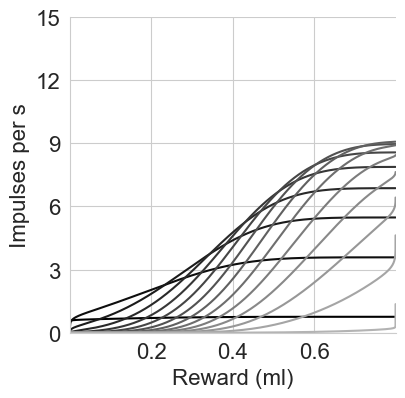

In [100]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

colors = np.linspace(0, 0.7, ec_norm.N)

ymax = []
# subsample for only 1 third of ec_unfm.N
for i in range(ec_unfm.N):
    if i%3 == 0:
        plt.plot(ec_norm.x, ec_norm.neurons_[i], color=str(colors[i]))
        ymax.append(ec_norm.neurons_[i][1499])
# plt.ylim((0,round(np.max(self.neurons_[self.N-2]),1)))

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Impulses per s')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

ax.set_yticks([0,3,6,9,12,15])

plt.xlim([0, 0.8])
plt.ylim([0, 15])
fig.savefig('./figures_rothenhoefer/'+'neuron_norm_pop_subsample.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'neuron_norm_pop_subsample.pdf', bbox_inches="tight")
plt.show()



In [101]:
# N_neurons = 40
# alpha = 0.5
# # others uses res.x
# R_t = 150
# slope_scale = 0.3
# spon_act = 3.92
#
# # cal slopes using spon_act
#
# ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
# ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
#


norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

(10000,)


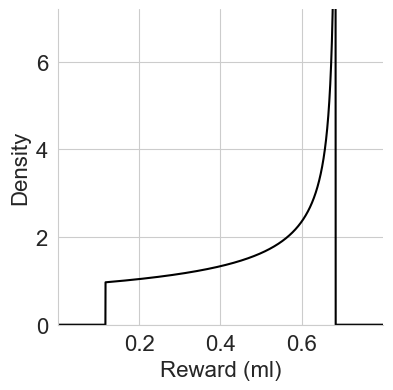

In [102]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

midpoints = []
ymax = []
for i in range(ec_unfm.N):
    ymax.append(ec_unfm.neurons_[i][1499])

ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])



# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.max(), color=str(0.7))

# normalize ec_unfm.d_x so that area under curve is 1
# ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum(), color=str(0.7))



ax.plot(ec_unfm.x, ec_unfm.d_x/ec_unfm.d_x.sum()/ec_unfm._x_gap, color='k')

ax.set_yticks(np.arange(0, 7,2 ))

plt.ylim([0, 7.2])
plt.xlim([0, 0.8])
print(ec_norm.d_x.shape)
fig.savefig('./figures_rothenhoefer/'+'uniform_density_only.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'uniform_density_only.pdf', bbox_inches="tight")
plt.show()


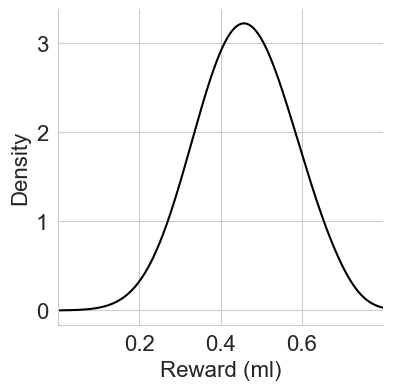

In [103]:
%matplotlib inline

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)
midpoints=[]
ymax = []
for i in range(ec_norm.N):
    ymax.append(ec_norm.neurons_[i][1499])

    # check if every points in ec_norm.neurons_[i] is smaller than spon_act
    if not np.all(ec_norm.neurons_[i] < spon_act):
        # print(np.argmin(np.abs(ec_norm.neurons_[i] - spon_act)))
        # append midpoints that is ec_unfm.neurons_[i] is closest to spon_act
        midpoints.append(ec_norm.x[np.argmin(np.abs(ec_norm.neurons_[i] - spon_act))])
    else:
        # APPEND nothing to midpoints
        ''


ax.set_xlabel('Reward (ml)')
ax.set_ylabel('Density')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([.2, .4, .6])

# set clean y ticks
ax.set_yticks(np.arange(0, 4,1 ))

# plt.ylim([0, 4])
plt.xlim([0, 0.8])


# normalize ec_norm.d_x so that area under curve is 1
ax.plot(ec_norm.x, ec_norm.d_x/ec_norm.d_x.sum()/ec_norm._x_gap, color='k')

fig.savefig('./figures_rothenhoefer/'+'normal_density.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'normal_density.pdf', bbox_inches="tight")
plt.show()

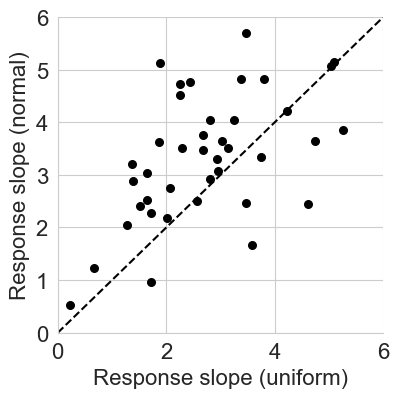

In [104]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(1,1)
np.random.seed(15)

# scatter plot of scatter(unfm_res, norm_res) and scatter(data[0], data[1]) and overlay them semi transparent

#ax scatter of unfm_res and norm_res with label='ours'




# plot fitting line for scatter plot
# plt.plot(np.unique(unfm_res), np.poly1d(np.polyfit(unfm_res, norm_res, 1))(np.unique(unfm_res)))
ax.scatter(data[:,0], data[:,1], color='k',label='Measured data' ,s=30)
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0]))) but for data[:,0] and data[:,1]
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0])))

# ax.legend()

ax.set_xlabel('Response slope (uniform)')
ax.set_ylabel('Response slope (normal)')
# overlay y=x dashed line from 0 to 6
ax.plot([0,6], [0,6], 'k--')

ax.set_xlim([0, 6])
# set fig's ylim
ax.set_ylim([0, 6])

# set y ticks every 1
ax.set_yticks(np.arange(0, 7,1 ))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)


# save the figure the name with alphae
fig.savefig('./figures_rothenhoefer/'+'alpha_true_.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'alpha_true_.pdf', bbox_inches="tight")

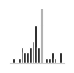

In [105]:
%matplotlib inline

fig,ax = plt.subplots(1,1)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# histogram along y=x
# plt.hist(unfm_res-norm_res, bins=20)
ax.hist(data[:,0]-data[:,1], bins=18, color= 'k')
# plot verical sloid line
ax.axvline(x=0, color=str(0.7), linestyle='-')

ax.set_yticks([])
ax.set_xticks([])

ax.set_ylim([0, 10])

# set y ticks


fig.set_figwidth(.7)
fig.set_figheight(.7)
plt.show()
fig.savefig('./figures_rothenhoefer/'+'histo_ori.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'histo_ori.pdf', bbox_inches="tight")



# plt.hist(unfm_res-norm_res, bins=20, alpha=0.5, label='ours')


In [106]:

# N_neurons = 40
# alpha = 0.7
# R_t = 150
# slope_scale = 0.3
# spon_act = 5
#
# # cal slopes using spon_act
#
# ec_norm = value_efficient_coding_ro('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)
# ec_unfm = value_efficient_coding_ro('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha, slope_scale = slope_scale)



norm_res = []
unfm_res = []
for i in range(N_neurons):
    norm_neg = ec_norm.neurons_[i][2500]-spon_act
    norm_0 = ec_norm.neurons_[i][5000]-spon_act
    norm_pos = ec_norm.neurons_[i][7500]-spon_act
    norm_res.append([norm_neg, norm_0, norm_pos])

    unfm_neg = ec_unfm.neurons_[i][2500]-spon_act
    unfm_0 = ec_unfm.neurons_[i][5000]-spon_act
    unfm_pos = ec_unfm.neurons_[i][7500]-spon_act
    unfm_res.append([unfm_neg, unfm_0, unfm_pos])

In [107]:
# wrapper_func_alpha_poisson but with one more argument that number of samples
def wrapper_func_alpha_poisson_samples(params):
    N_neurons = 40
    alpha_norm = params[0]
    alpha_unfm = params[1]
    # others uses res.x
    R_t = 100
    slope_scale_norm = params[2]
    slope_scale_unfm = params[3]
    spon_act = 5
    samples = params[4]

    # if any of params is equal or smaller than 0, return a large number
    if alpha_norm <= 0 or alpha_unfm <= 0 or slope_scale_norm <= 0 or slope_scale_unfm <= 0:
        return 1e5

    # cal slopes using spon_act

    ec_norm = value_efficient_coding_moment('normal', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_norm, slope_scale = slope_scale_norm)
    ec_unfm = value_efficient_coding_moment('uniform', N_neurons=N_neurons, R_t=R_t, X_OPT_ALPH= alpha_unfm, slope_scale = slope_scale_unfm)

    norm_res = []
    unfm_res = []
    for i in range(N_neurons):
        # poisson sapmling using norm_neg, norm_0, norm_pos but 100 samples
        norm_neg = np.random.poisson(ec_norm.neurons_[i][2500], samples)
        norm_0 = np.random.poisson(ec_norm.neurons_[i][5000], samples)
        norm_pos = np.random.poisson(ec_norm.neurons_[i][7500], samples)

        #take mean of norm_neg, norm_0, norm_pos
        norm_neg = np.mean(norm_neg)
        norm_0 = np.mean(norm_0)
        norm_pos = np.mean(norm_pos)

        norm_neg -= spon_act
        norm_0 -= spon_act
        norm_pos-= spon_act
        norm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [norm_neg, norm_0, norm_pos]))

        unfm_neg = np.random.poisson(ec_unfm.neurons_[i][2500], samples)
        unfm_0 = np.random.poisson(ec_unfm.neurons_[i][5000], samples)
        unfm_pos = np.random.poisson(ec_unfm.neurons_[i][7500], samples)

        #take mean of unfm_neg, unfm_0, unfm_pos
        unfm_neg = np.mean(unfm_neg)
        unfm_0 = np.mean(unfm_0)
        unfm_pos = np.mean(unfm_pos)

        unfm_neg -= spon_act
        unfm_0 -= spon_act
        unfm_pos -= spon_act

        unfm_res.append(estimate_slope_fitwith_intercept([0.2,0.4,0.6], [unfm_neg, unfm_0, unfm_pos]))

    return norm_res, unfm_res


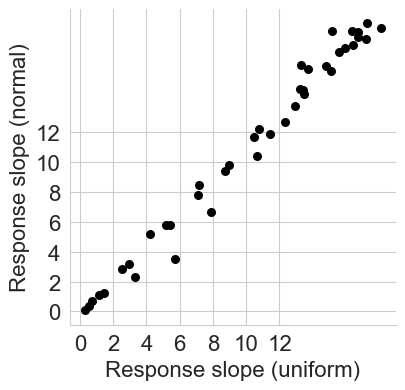

In [108]:
%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(1,1)
np.random.seed(100)

norm_res, unfm_res = wrapper_func_alpha_poisson_samples([alpha_norm, alpha_unfm,
                                                         slope_scale_norm, slope_scale_unfm, 100])

# scatter plot of scatter(unfm_res, norm_res) and scatter(data[0], data[1]) and overlay them semi transparent

#ax scatter of unfm_res and norm_res with label='ours'




ax.scatter(unfm_res, norm_res, color='k', label='Our model', s=30)
# plot fitting line for scatter plot
# plt.plot(np.unique(unfm_res), np.poly1d(np.polyfit(unfm_res, norm_res, 1))(np.unique(unfm_res)))
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0]))) but for data[:,0] and data[:,1]
# plt.plot(np.unique(data[:,0]), np.poly1d(np.polyfit(data[:,0], data[:,1], 1))(np.unique(data[:,0])))

# ax.legend()

ax.set_xlabel('Response slope (uniform)')
ax.set_ylabel('Response slope (normal)')
# overlay y=x dashed line from 0 to 6
# ax.plot([0,12], [0,12], 'k--')
# ax.set_xlim([0, 12])
# ax.set_ylim([0, 12])



# set x and y axis ticks
ax.set_xticks(np.arange(0,13,2))
ax.set_yticks(np.arange(0,13,2))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


fig.set_figwidth(4.2)
fig.set_figheight(4.1)

#legend but that is smaller
# ax.legend(fontsize=12)

# save the figure the name with alphae
fig.savefig('./figures_rothenhoefer/alpha_poisson_model.png', bbox_inches="tight")
# save in pdf
fig.savefig('./figures_rothenhoefer/alpha_poisson_model.pdf', bbox_inches="tight")


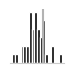

In [110]:
%matplotlib inline

fig,ax = plt.subplots(1,1)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# histogram along y=x
# plt.hist(unfm_res-norm_res, bins=20)
ax.hist(np.array(unfm_res)-np.array(norm_res), bins=18, color= 'k')
# plot verical sloid line
ax.axvline(x=0, color=str(0.7), linestyle='-')

ax.set_yticks([])
ax.set_xticks([])
# set y ticks


fig.set_figwidth(.7)
fig.set_figheight(.7)
fig.savefig('./figures_rothenhoefer/'+'histo_our.png', bbox_inches="tight")
fig.savefig('./figures_rothenhoefer/'+'histo_our.pdf', bbox_inches="tight")



# plt.hist(unfm_res-norm_res, bins=20, alpha=0.5, label='ours')


In [111]:
np.sum((np.array(unfm_res)-np.array(norm_res))<0)

31